# Load the data and set up the environment

In [1]:
!pip install -q kaggle

In [2]:
# fucntions related package
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile
from shutil import copyfile
from tqdm import tqdm
import random
import glob
# data visulization related package
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# deep learning related package
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

# evaluation related package
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

### Must upload the Kaggle.json before using the kaggle api

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the full dataset , this will be a zip file
!kaggle datasets download muratkokludataset/rice-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
 59% 130M/219M [00:00<00:00, 1.36GB/s]
100% 219M/219M [00:00<00:00, 1.37GB/s]


In [5]:
# set the path to extract the data
data_path = "rice_data"

# create the path
os.makedirs(data_path, exist_ok=True)

# extract all the data
with ZipFile("rice-image-dataset.zip", 'r') as zip_ref:
    all_files = zip_ref.namelist()
    for file in tqdm(all_files):
        zip_ref.extract(file, path=data_path)

100%|██████████| 75001/75001 [00:08<00:00, 8628.95it/s]


#  Identify a Deep Learning Problem (5 points)

## Description on the problem


This project focuses on using Convolutional Neural Networks (CNNs) to classify rice varieties based on image data.

The dataset contains images of five diffrent varieties of rice:

  * Arborio
	* Basmati
	* Ipsala
	* Jasmine
	* Karacadag

The goal is to train a Deep Learning model that can  recognize the rice variety from a given image.

## Description on the data

The data is from Kaggle : https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data

There are 5 folders for 5 different rice type, each folder contain 15,000 images.

# Exploratory Data Analysis (EDA)  (34 points)
- Inspect, Visualize, and Clean the Data (34 points)


## See the Distribution of the data

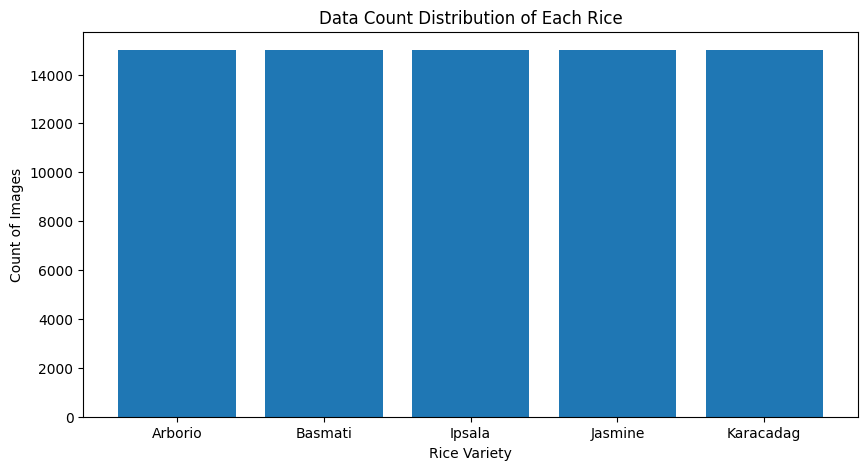

In [6]:
# set the path to the data
folder_path = "rice_data/Rice_Image_Dataset"

# set the rice varieties
rice_varieties = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# init an empty list for the count
image_counts = []

for variety in rice_varieties:
    variety_path = os.path.join(folder_path, variety)
    count = len(os.listdir(variety_path))
    image_counts.append(count)

# showing the plt
plt.figure(figsize=(10, 5))
plt.bar(rice_varieties, image_counts)
plt.xlabel("Rice Variety")
plt.ylabel("Count of Images")
plt.title("Data Count Distribution of Each Rice")

# sho the plt
plt.show()

They all have 15,000 images, so there is no need to re-sample the data

## See the size of the images

In [7]:

# init the empty list for the wid
widths = []
heights = []

for variety in rice_varieties:
    image_folder= os.listdir(os.path.join(folder_path, variety))

    # randomly select 1000 images for the calculation of the
    sample_files = random.sample(image_folder, 1000)

    for file in sample_files:
        image_path = os.path.join(os.path.join(folder_path, variety), file)
        image = Image.open(image_path)
        # get the size measured by pixel
        width, height = image.size
        # add them to the list
        widths.append(width)
        heights.append(height)

average_width = np.mean(widths)
average_height = np.mean(heights)

print(f"Average  Width Pixel: {average_width} ")
print(f"Average  Height Pixel: {average_height} ")

Average  Width Pixel: 250.0 
Average  Height Pixel: 250.0 


The original size is too big, will rescale them all into 100 * 100.


## check the colour of the image

There are 5 * 15,000 image, unless i have to , i would like to remove the R,G,B channels to save some calculation

In [8]:

# save the average R G B values
average_rgb_values = []

for variety in rice_varieties:
    image_files = os.listdir(os.path.join(folder_path, variety))
    # randomly select 1000 image of each folder
    sample_files = random.sample(image_files, 1000)
    # init empty list for each colours
    Red_values = []
    Green_values= []
    Blue_values = []

    for file in sample_files:
        image_path = os.path.join(os.path.join(folder_path, variety), file)
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image).astype(np.float32)
        # append the R G B value to the list
        Red_values.append(np.mean(image_np[:, :, 0]))
        Green_values.append(np.mean(image_np[:, :, 1]))
        Blue_values.append(np.mean(image_np[:, :, 2]))

    # calculate the mean value  from the list
    Average_Red = np.mean(Red_values)
    Average_Green = np.mean(Green_values)
    Average_Blue = np.mean(Blue_values)
    # append them to the list of all three RGB colour
    average_rgb_values.append([Average_Red, Average_Green, Average_Blue])

# conver the list to a NP ARRAY!!!!!
avg_rgb_values = np.array(average_rgb_values)



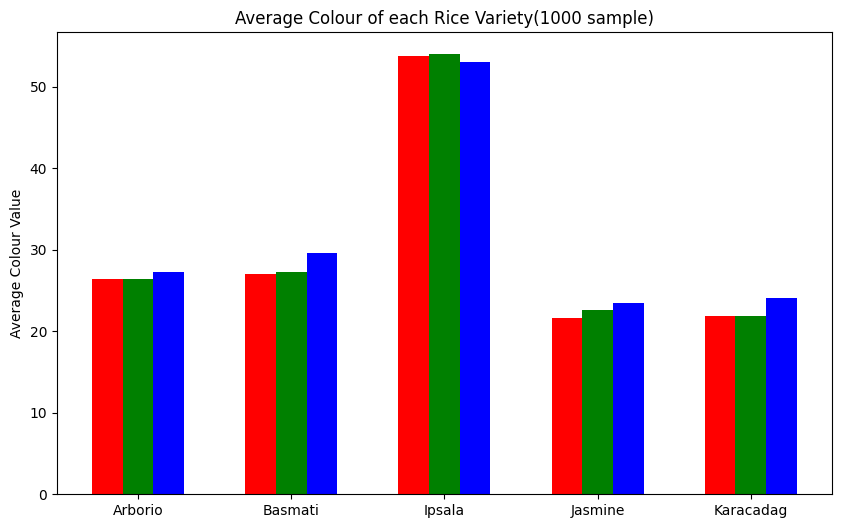

In [9]:

# draw the plot
column = np.array([0, 1, 2, 3, 4])

# set the size of the plot
plt.figure(figsize=(10, 6))

# configur the
plt.bar(column - 0.2, avg_rgb_values[:, 0], width=0.2, color='Red')

plt.bar(column, avg_rgb_values[:, 1], width=0.2, color='Green')

plt.bar(column + 0.2, avg_rgb_values[:, 2], width=0.2, color='Blue')

plt.xticks(column, rice_varieties)

plt.ylabel("Average Colour Value")

plt.title("Average Colour of each Rice Variety(1000 sample)")


# see the plot
plt.show()

There is no significant difference in colour values among the R, G, and B channels.

Therefore, I will use only the grayscale channel for CNN models.

## See the rice images of each type

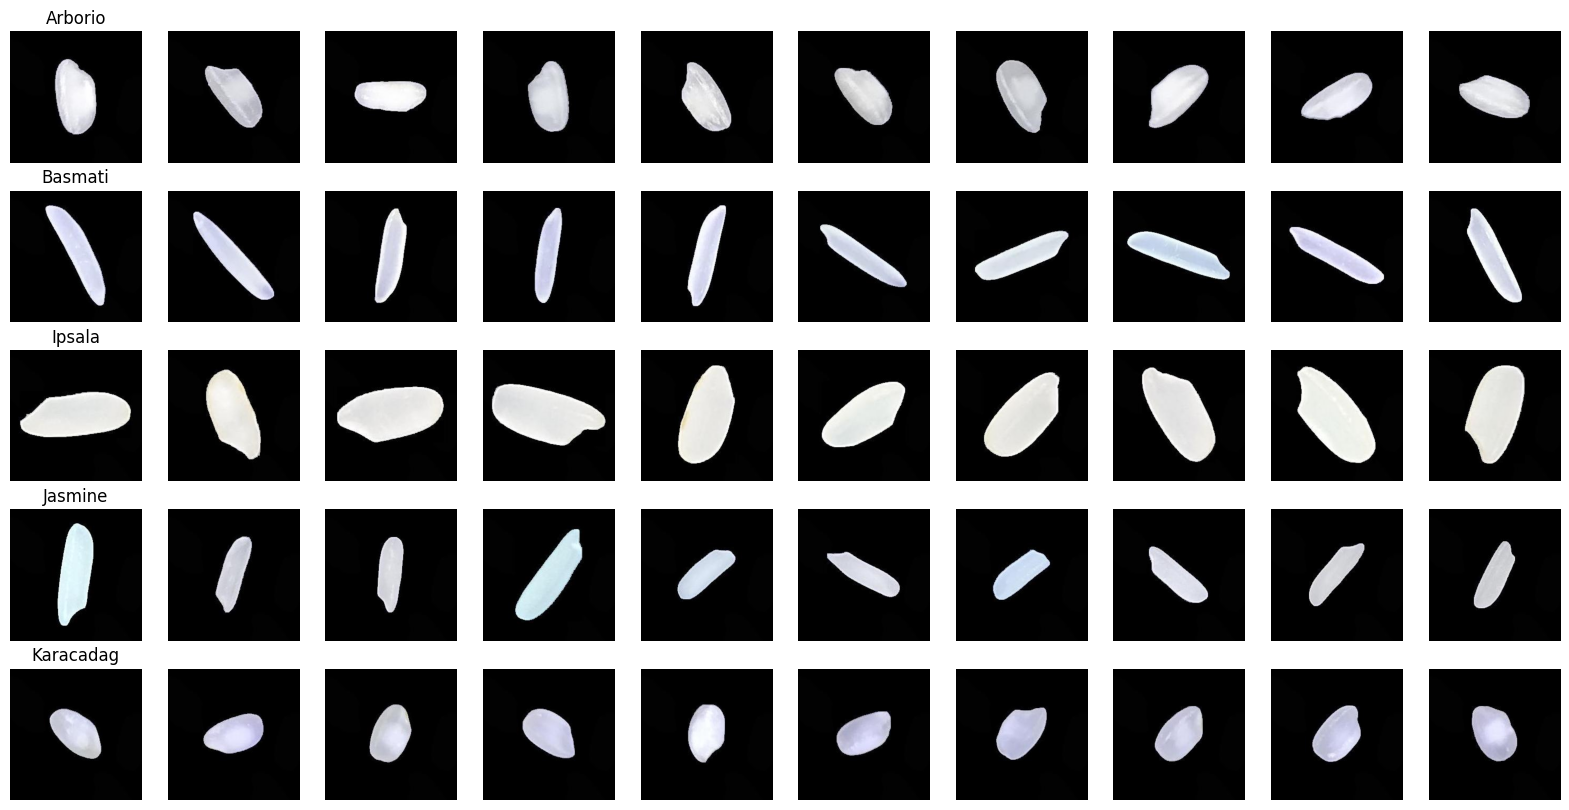

In [10]:
#  must be same to the name of folder
rice_varieties = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

_, sub_plots = plt.subplots(5, 10, figsize=(20, 10))

for row_index, rice_variety in enumerate(rice_varieties):
    # set the path to the folder
    folder_path = os.path.join("rice_data/Rice_Image_Dataset", rice_variety)
    # randomly select 10 images
    for column_index, image_name in enumerate(random.sample(os.listdir(folder_path), 10)):
        image_path = os.path.join(folder_path, image_name)
        image = Image.open(image_path)
        # remove the axis
        sub_plots[row_index, column_index].axis('off')
        # show the image of each variety
        sub_plots[row_index, column_index].imshow(image)
        # set the sub title
        if column_index == 0:
            sub_plots[row_index, column_index].set_title(rice_variety)
plt.show()

## Determine if any data needs to be transformed.
For example, if you're planning on using an SVM method for prediction, you may need to normalize or scale the data if there is a considerable difference in the range of the data.

Data augmentation will be implemented to prevent the CNN models from overfitting

# Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions (65 points)

Start the main analysis (the main analysis refers to supervised learning tasks such as classification or regression). Depending on your project, you may have one model or more. Generally, it is deemed a higher quality project if you compare multiple models and show your understanding of why specific models work better than the other or what limitations or cautions specific models may have. For machine learning models, another recommendation is to show enough effort on the hyperparameter optimization.

 If your project involves making a web app (not required), you can include the demo.

## Data Pre-processing

### Split the data into train and validation

In [11]:
# set the dataset path the folder name
dataset_path = "rice_data/Rice_Image_Dataset"
rice_varieties = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

image_paths = []
labels = []

for variety in rice_varieties:
    variety_path = os.path.join(dataset_path, variety)
    image_files = glob.glob(os.path.join(variety_path, '*'))
    for image in image_files:
      relative_path = os.path.join(variety, os.path.basename(image))
      image_paths.append(relative_path)
      labels.append(variety)

# use the folder name as the label
# create a dafafram that has two column
# one column for the image name
# one column for the label
df = pd.DataFrame({'image_name': image_paths,'image_label': labels})


# must stratify by the label , so for each variety , it will have 70 for train, and 30 for validation
# this will avoid the Bias caused by imbalance dataset.
train_df, validate_df = train_test_split(df,test_size=0.3,
                                         stratify=df['image_label'],
                                         random_state=2025)



Conver the text rice varieties to number

In [12]:
# overwrite just in case
rice_varieties =["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# init a empty dictionary  for mapping the label to the index
label_to_index ={}

for index, variety in enumerate(rice_varieties):
    label_to_index[variety] = index

# map the label to number
train_df['label_index'] = train_df['image_label'].map(label_to_index)
validate_df['label_index'] = validate_df['image_label'].map(label_to_index)

In [13]:
print(label_to_index)

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


## Use tensorflow create image pipline

In [14]:
# create a function to do the data augment
def image_preprocess_augment(path, label):
        path_to_image = tf.strings.join([dataset_path, "/", path])
        #use image to point to the image
        image = tf.io.read_file(path_to_image)
        #since all the R B G values are similar, only use the grey channels
        #decode it first
        image = tf.image.decode_jpeg(image, channels=1)
        #then resize all the image to 100 * 100
        image = tf.image.resize(image, [100, 100])

        left_right_flip = tf.random.uniform(())
        up_down_flip = tf.random.uniform(())
        random_zoom = tf.random.uniform(())

        if left_right_flip >= 0.2025:
          image = tf.image.random_flip_left_right(image)
        if up_down_flip >= 0.2025:
          image = tf.image.random_flip_up_down(image)

        if random_zoom >= 0.2025:
          zoom_level = tf.random.uniform((), 0.7, 1)
          # must use tf.int32!!!!!!
          new_size = tf.cast(zoom_level * 100 ,tf.int32)

          image = tf.image.random_crop(image, size=[new_size, new_size, 1])
          #resize back to  100 x100
          image = tf.image.resize(image, [100, 100])

        # make sure the value between 0-1
        Final_Image = tf.cast(image,tf.float32) / 255

        return Final_Image, tf.one_hot(label, depth= 5)

In [15]:
def tensorflow_image_pipline(df, batch_size, shuffle):

    paths_of_images ,labels_of_images = df['image_name'], df['label_index']

    pipeline = tf.data.Dataset.from_tensor_slices((paths_of_images, labels_of_images))
    # if the shuffle is true then use the reshuffle_each_iteration=True to
    # make sure each epoch the data is different
    if shuffle is True:
        pipeline = pipeline.shuffle(buffer_size=len(df),
                                  reshuffle_each_iteration=True)

    # do the process in batch, so that the cpu and disk will not be the bottle neck
    pipeline = pipeline.map(image_preprocess_augment,
                          num_parallel_calls=tf.data.AUTOTUNE)

    return pipeline.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [16]:
# use the create_data to create the data
# using A100, set the batch size to be 1000 to save time
# reshuffle_each_iteration=True will make sure each epoch the data is different
train_pipeline = tensorflow_image_pipline(train_df, batch_size=1000, shuffle=True)
# must use the
validation_pipeline = tensorflow_image_pipline(validate_df, batch_size=1000, shuffle=False)

## Model Architecture



## First Model ,Baseline CNN model


In [17]:
Baseline_cnn_model = models.Sequential([
    # first layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),

    # max pooling
    layers.MaxPooling2D(2, 2),

    # second layer
    layers.Conv2D(32, (3, 3), activation='relu'),

    # max pooling again
    layers.MaxPooling2D(2, 2),

    # make it into one dimention
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(5, activation='softmax')
])

Baseline_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# set the early stop
# if the accuracy does not improve for more than 2 epoc, then stop !
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=3,
                           restore_best_weights=True,
                           # set one so i can see the step
                           verbose=1)

In [19]:
# see the structure of the first model
Baseline_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16928)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       541,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,461 (2.10 MB)

 Trainable params: 551,461 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# see if the GPU is A100
!nvidia-smi

Sat Jun  7 18:20:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             52W /  400W |     439MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [21]:
Baseline_cnn_model_history = Baseline_cnn_model.fit(
    train_pipeline,
    validation_data=validation_pipeline,
    epochs=20,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.4964 - loss: 1.1811 - val_accuracy: 0.7790 - val_loss: 0.5764
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.7983 - loss: 0.5169 - val_accuracy: 0.8320 - val_loss: 0.4195
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.8580 - loss: 0.3715 - val_accuracy: 0.8844 - val_loss: 0.3097
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.8686 - loss: 0.3267 - val_accuracy: 0.8937 - val_loss: 0.2816
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8948 - loss: 0.2794 - val_accuracy: 0.9020 - val_loss: 0.2639
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9024 - loss: 0.2569 - val_accuracy: 0.9061 - val_loss: 0.2469
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9018 - loss: 0.2559 - val_accuracy: 0.9001 - val_loss: 0.2488
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9072 - loss: 0.2384 - val_accuracy: 0.9248 -

Visulization of the training process

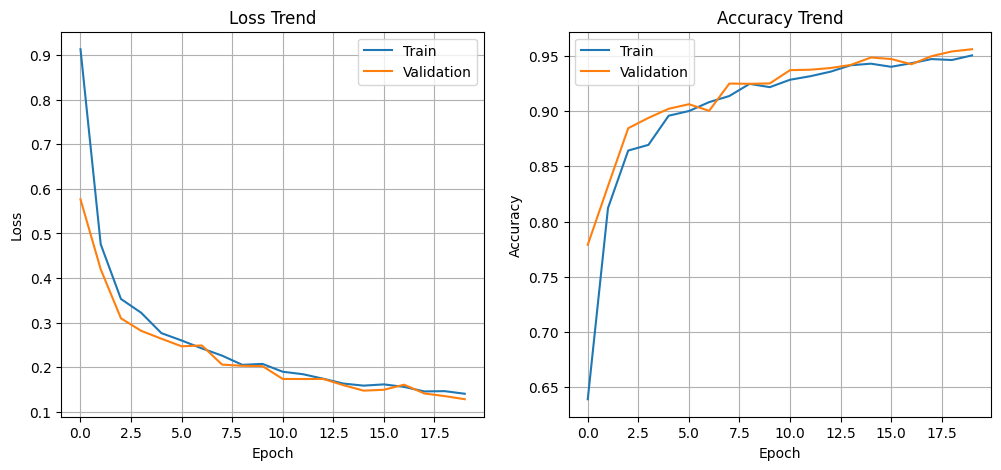

In [22]:
history = Baseline_cnn_model_history.history

# set the size for the plot
plt.figure(figsize=(12, 5))

# set the location
plt.subplot(1, 2, 1)
# set the laebl
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Trend')
plt.legend()
plt.grid(True)


plt.show()

No overfitting, the loss value on both Train and Validation dataset
are both dropping

The model is not bias on the Trainig dataset, the model have a good accuracy on the validation dataset

In [23]:
## save the  model
Baseline_cnn_model.save_weights("Baseline.weights.h5")

## Second Model , features tunining CNN model


In [24]:
Second_cnn_model = models.Sequential([
    layers.Conv2D(256, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    # add a new layer
    # randomly force 30% of the nodes not wokring
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
     # make it into one dimention
    layers.Flatten(),
    # randomly force 30% of the nodes not wokring
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(5, activation='softmax')  ])

# the learning rate of adam us 0.001
Second_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
# see the structure of the second model
Second_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 98, 98, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 49, 49, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 47, 47, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 576,389 (2.20 MB)

 Trainable params: 576,389 (2.20 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:


# fit the model for 20 epochs
Second_cnn_model_history= Second_cnn_model.fit(
    train_pipeline,
    validation_data=validation_pipeline,
    epochs=20,
    callbacks=[early_stop]
)



Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 582ms/step - accuracy: 0.5060 - loss: 1.1122 - val_accuracy: 0.8552 - val_loss: 0.3726
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.8590 - loss: 0.3540 - val_accuracy: 0.9034 - val_loss: 0.2585
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.9048 - loss: 0.2549 - val_accuracy: 0.9315 - val_loss: 0.1914
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.9242 - loss: 0.2034 - val_accuracy: 0.9400 - val_loss: 0.1688
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.9364 - loss: 0.1780 - val_accuracy: 0.9491 - val_loss: 0.1405
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.9413 - loss: 0.1588 - val_accuracy: 0.9585 - val_loss: 0.1220
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.9516 - loss: 0.1364 - val_accuracy: 0.9590 - val_loss: 0.1150
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.9531 - loss: 0.1300 - val_accu

Visulization of the training process

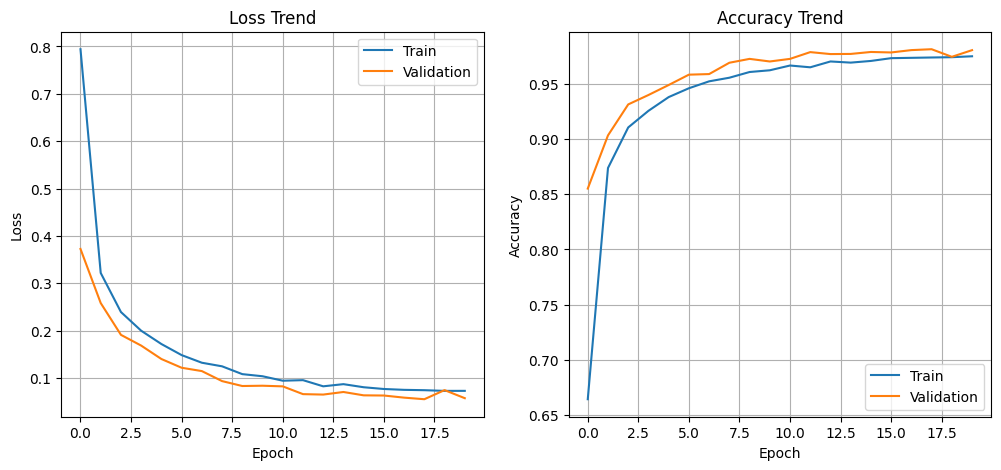

In [27]:
history = Second_cnn_model_history.history

# set the size for the plot
plt.figure(figsize=(12, 5))

# set the location
plt.subplot(1, 2, 1)
# set the laebl
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Trend')
plt.legend()
plt.grid(True)


plt.show()

Result is very similar to the baseline model
No overfitting, the loss value on both Train and Validation dataset
are both dropping

The model is not bias on the Trainig dataset, the model have a good accuracy on the validation dataset

In [28]:
## save the  model
Second_cnn_model.save_weights("Second_cnn.weights.h5")

## Reload the models

In [29]:
# load it to save time
Baseline_cnn_model.load_weights("Baseline.weights.h5")

In [30]:
# load it to save time
Second_cnn_model.load_weights("Second_cnn.weights.h5")

## Results and Analysis



### Result of Baseline CNN model

In [31]:
# init empty list for the prediciton and the real y value
Baseline_y_prediction = []
y_real = []

for images, labels in validation_pipeline:
    # get the prediciton and the real value
    predictions = Baseline_cnn_model.predict(images)
    # append them to the list
    Baseline_y_prediction.append(predictions)

    y_real.append(labels.numpy())

y_real = np.vstack(y_real)
Baseline_y_prediction = np.vstack(Baseline_y_prediction)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [32]:
y_real_labels = np.argmax(y_real, axis=1)
Baseline_y_predicted_labels = np.argmax(Baseline_y_prediction, axis=1)

# print the classifiction report
print("Baseline CNN Classification Report")
print(classification_report(y_real_labels, Baseline_y_predicted_labels))

Baseline CNN Classification Report
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      4500
           1       0.95      0.97      0.96      4500
           2       0.99      0.99      0.99      4500
           3       0.95      0.94      0.95      4500
           4       0.93      0.94      0.94      4500

    accuracy                           0.95     22500
   macro avg       0.95      0.95      0.95     22500
weighted avg       0.95      0.95      0.95     22500



In [33]:
auc_score = roc_auc_score(y_real_labels, Baseline_y_prediction, multi_class='ovr')
print("Baseline CNN model Area Under Curve:", auc_score)

Baseline CNN model Area Under Curve: 0.9970613629629629


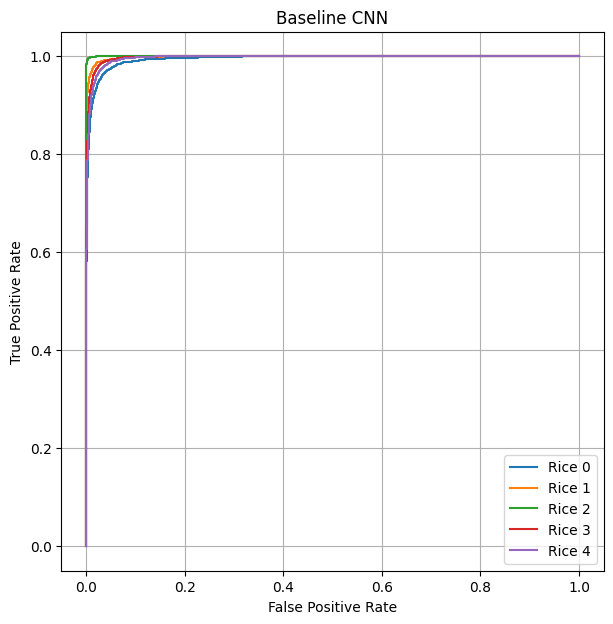

In [34]:
# print the plot for the Area under curve
# must set the plt first
plt.figure(figsize=(7, 7))
for i in range(y_real.shape[1]):
    false_positive_rate, true_positive_rate, _ = roc_curve(y_real[:, i], Baseline_y_prediction[:, i])
    plt.plot(false_positive_rate, true_positive_rate, label=f'Rice {i}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline CNN')
plt.legend()
plt.grid()
plt.show()

### Result of Second CNN model


### Result of Baseline CNN model

In [35]:
# init empty list for the prediciton and the real y value
Second_CNN_y_prediction = []
y_real = []

for images, labels in validation_pipeline:
    # get the prediciton and the real value
    predictions = Second_cnn_model.predict(images)
    # append them to the list
    Second_CNN_y_prediction.append(predictions)

    y_real.append(labels.numpy())

y_real = np.vstack(y_real)
Second_CNN_y_prediction = np.vstack(Second_CNN_y_prediction)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [36]:
y_real_labels = np.argmax(y_real, axis=1)
Second_CNN_y_predicted_labels = np.argmax(Second_CNN_y_prediction, axis=1)

# print the classifiction report
print("Second CNN Classification Report")
print(classification_report(y_real_labels, Second_CNN_y_predicted_labels))

Second CNN Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4500
           1       0.98      0.99      0.99      4500
           2       1.00      0.99      1.00      4500
           3       0.98      0.98      0.98      4500
           4       0.97      0.98      0.98      4500

    accuracy                           0.98     22500
   macro avg       0.98      0.98      0.98     22500
weighted avg       0.98      0.98      0.98     22500



In [37]:
auc_score = roc_auc_score(y_real, Second_CNN_y_prediction, multi_class='ovr')  # or 'ovo'
print("Second CNN model Area Under Curve:", auc_score)

Second CNN model Area Under Curve: 0.9993211222222221


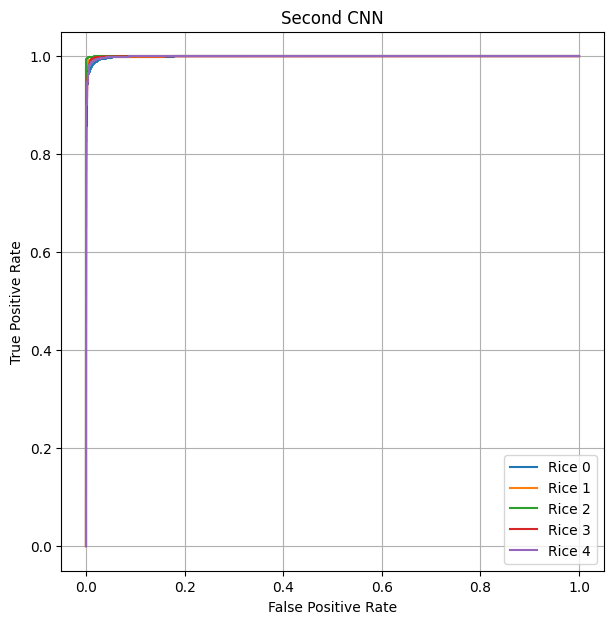

In [38]:
# print the plot for the Area under curve
plt.figure(figsize=(7, 7))
for i in range(y_real.shape[1]):
    false_positive_rate, true_positive_rate, _ = roc_curve(y_real[:, i], Second_CNN_y_prediction[:, i])
    plt.plot(false_positive_rate, true_positive_rate, label=f'Rice {i}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Second CNN')
plt.legend()
plt.grid()
plt.show()

## Conclusion

In this project, I built a very efficient data pipeline using TensorFlow. By using techniques such as batching, prefetching, and parallel data loading (num_parallel_calls=tf.data.AUTOTUNE), I significantly accelerated the data input process. This eliminated CPU and disk as bottlenecks, allowing the A100 GPU’s computational power to be fully utilized.

Additionally, I integrated image augmentation into the data pipeline — including random horizontal and vertical flips, as well as random zoom and cropping — which greatly improved the model’s generalization capability. To further reduce overfitting, I added dropout layers to the model architecture, enhancing its robustness during training.

Compared to my first CNN project, the key improvement here is the use of TensorFlow’s optimized data pipeline, which dramatically sped up training and enabled full GPU acceleration. The combination of data augmentation and regularization techniques resulted in a highly accurate and very well generalized model, with very good performance on both training and validation datasets.